# using YOLOv3 for object detection
This is a modified version of source https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb

Redmon et al., 2016 and Redmon and Farhadi, 2016.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/4thbrain/week6')

In [ ]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 413, done.
remote: Total 413 (delta 0), reused 0 (delta 0), pack-reused 413
Receiving objects: 100% (413/413), 4.23 MiB | 1.63 MiB/s, done.
Resolving deltas: 100% (237/237), done.
/content/drive/MyDrive/Colab Notebooks/4thbrain/week6/yolov3-tf2
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/4thbrain/week6/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.7MB 39kB/s 
     |████████████████████████████████| 28.7MB 69.8MB/s 
     |████████████████████████████████| 2.9MB 38.2MB/s 
     |████████████████████████████████| 471kB 40.9MB/s 
     |████████████████████████████████| 3.8MB 23.7MB/s 
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0

In [ ]:
#%cd yolov3-tf2
!ls

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


In [ ]:
import tensorflow as tf
tf.__version__

'2.4.0'


retrieve pretained model + weights from  DarkNet: https://towardsdatascience.com/custom-object-detection-using-darknet-9779170faca2

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-06-30 18:46:03--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  19.2MB/s    in 13s     

2021-06-30 18:46:17 (17.9 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-06-30 18:46:18.600037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-06-30 18:46:20.277677: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-30 18:46:20.278554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-06-30 18:46:20.327663: I tensorflow/stream_executor/cuda/cuda_gpu_exec

In [ ]:
# import sys
# from absl import app, logging, flags
# from absl.flags import FLAGS

# def del_all_flags(FLAGS):
#     flags_dict = FLAGS._flags()    
#     keys_list = [keys for keys in flags_dict]    
#     for keys in keys_list:
#         FLAGS.__delattr__(keys)

# del_all_flags(flags.FLAGS)

In [ ]:
# FLAGS.num_classes

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')

#Sample image is girl.png within data folder. 80 classes detection from MS COCO data set.
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#FLAGS.image = 'data/test_images/0004.jpg'  #'data/street.jpg'#

def pretrdet(pathy):
  FLAGS.image = pathy
  if FLAGS.tiny:
      yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  else:
      yolo = YoloV3(classes=FLAGS.num_classes)
        
  yolo.load_weights(FLAGS.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0630 18:46:45.223695 140640360896384 <ipython-input-10-1b8b83377263>:12] weights loaded
I0630 18:46:45.228287 140640360896384 <ipython-input-10-1b8b83377263>:15] classes loaded
I0630 18:46:46.726457 140640360896384 <ipython-input-10-1b8b83377263>:26] time: 1.4645752906799316
I0630 18:46:46.727996 140640360896384 <ipython-input-10-1b8b83377263>:28] detections:
I0630 18:46:46.733392 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9966800212860107, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0630 18:46:46.737503 140640360896384 <ipython-input-10-1b8b83377263>:32] 	bus, 0.9951198101043701, [0.67014587 0.17855005 0.9937171  0.5290146 ]
I0630 18:46:46.741506 140640360896384 <ipython-input-10-1b8b83377263>:32] 	person, 0.9870266914367676, [0.6138846 0.3450544 0.6877058 0.7753   ]
I0630 18:46:46.745041 140640360896384 <ipython-input-10-1b8b83377263>:32] 	bus, 0.9826598763465881, [0.3228875  0.15145975 0.6138201  0.506682  ]
I0630 18:46:46.748680 140640360896384 <ipython-input-1

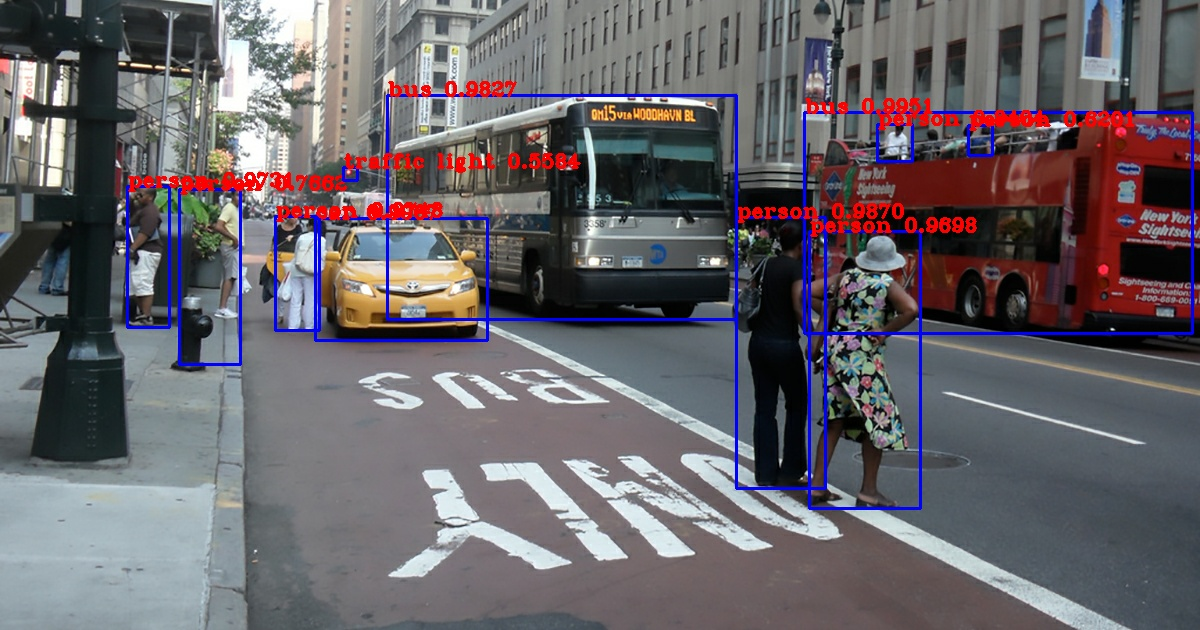

In [ ]:
pretrdet('data/street.jpg')

In [ ]:
# from IPython.core.display import Image as image
# from PIL import Image

# def save_and_display(arr, fname):
#     pilimg = Image.fromarray(arr)
#     pilimg.save(fname)
#     return image(filename=fname, width=800)

In [ ]:
# save_and_display(img, 'jiraffe.jpg')

I0630 18:49:05.317589 140640360896384 <ipython-input-10-1b8b83377263>:12] weights loaded
I0630 18:49:05.321001 140640360896384 <ipython-input-10-1b8b83377263>:15] classes loaded
I0630 18:49:06.657762 140640360896384 <ipython-input-10-1b8b83377263>:26] time: 0.07799434661865234
I0630 18:49:06.658918 140640360896384 <ipython-input-10-1b8b83377263>:28] detections:
I0630 18:49:06.668637 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9945942759513855, [0.08390437 0.4181878  0.17409326 0.47571415]
I0630 18:49:06.672593 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9919448494911194, [0.00217113 0.45459333 0.09452537 0.57086265]
I0630 18:49:06.677456 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9793890118598938, [0.30968887 0.39875886 0.4104424  0.45354083]
I0630 18:49:06.681375 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9760374426841736, [0.4204707  0.3865328  0.50878394 0.43637237]
I0630 18:49:06.686771 140640360896384 <ipython-input

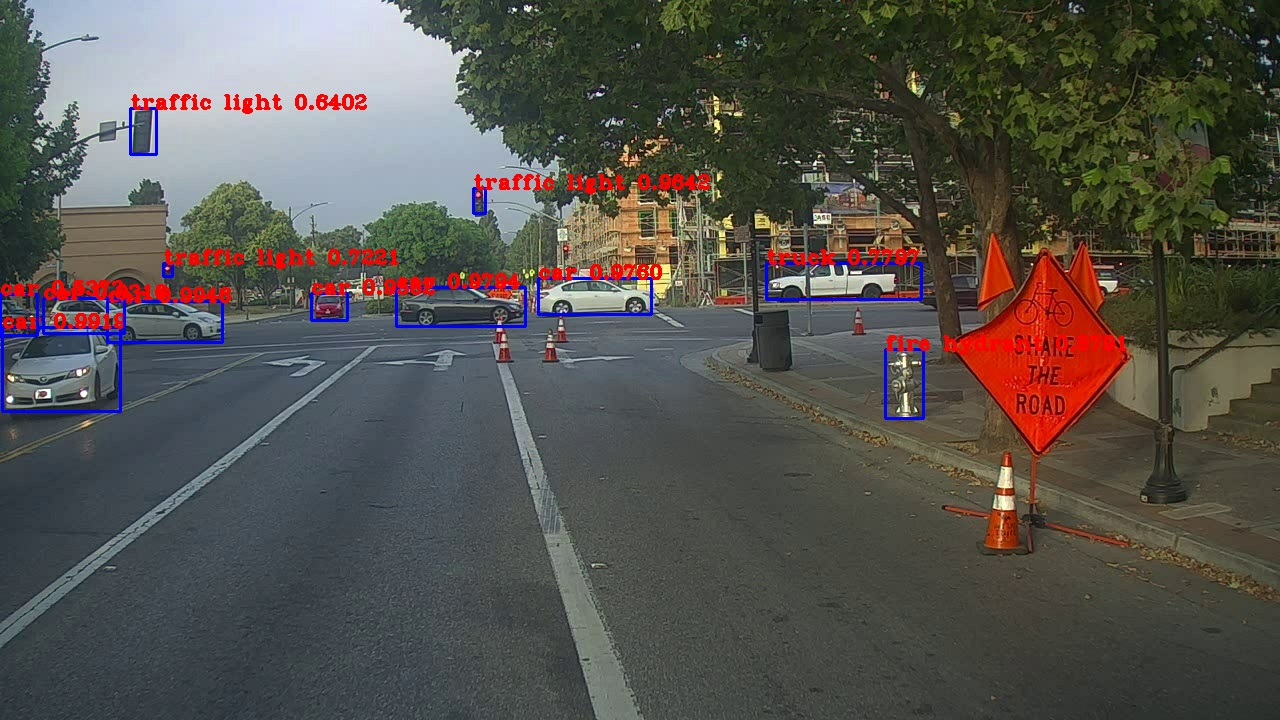

In [ ]:
pretrdet('data/test_images/0004.jpg')

I0630 18:50:30.592751 140640360896384 <ipython-input-10-1b8b83377263>:12] weights loaded
I0630 18:50:30.595983 140640360896384 <ipython-input-10-1b8b83377263>:15] classes loaded
I0630 18:50:31.516188 140640360896384 <ipython-input-10-1b8b83377263>:26] time: 0.08370566368103027
I0630 18:50:31.517309 140640360896384 <ipython-input-10-1b8b83377263>:28] detections:
I0630 18:50:31.524375 140640360896384 <ipython-input-10-1b8b83377263>:32] 	giraffe, 0.9978438019752502, [0.30420482 0.0965673  0.8799007  0.8699311 ]
I0630 18:50:31.527327 140640360896384 <ipython-input-10-1b8b83377263>:32] 	zebra, 0.8449257016181946, [0.52784646 0.40066803 0.8689227  0.90139806]


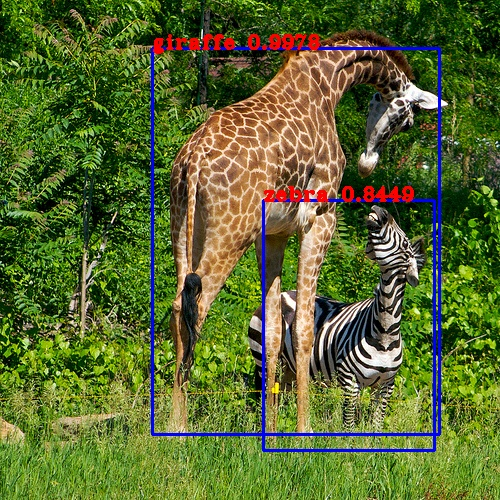

In [ ]:
pretrdet('data/test_images/giraffe.jpg')

I0630 18:50:39.326377 140640360896384 <ipython-input-10-1b8b83377263>:12] weights loaded
I0630 18:50:39.329404 140640360896384 <ipython-input-10-1b8b83377263>:15] classes loaded
I0630 18:50:39.936323 140640360896384 <ipython-input-10-1b8b83377263>:26] time: 0.08089661598205566
I0630 18:50:39.937483 140640360896384 <ipython-input-10-1b8b83377263>:28] detections:
I0630 18:50:39.945084 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9992826581001282, [0.27649012 0.4105447  0.59023607 0.896624  ]
I0630 18:50:39.948029 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9985067844390869, [0.59527993 0.3980793  0.7218013  0.56224144]
I0630 18:50:39.951706 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.996269941329956, [0.7381854  0.44752878 1.0068752  0.9742908 ]
I0630 18:50:39.955370 140640360896384 <ipython-input-10-1b8b83377263>:32] 	car, 0.9922270774841309, [0.7231026  0.4083751  0.82352275 0.5277095 ]
I0630 18:50:39.960214 140640360896384 <ipython-input-

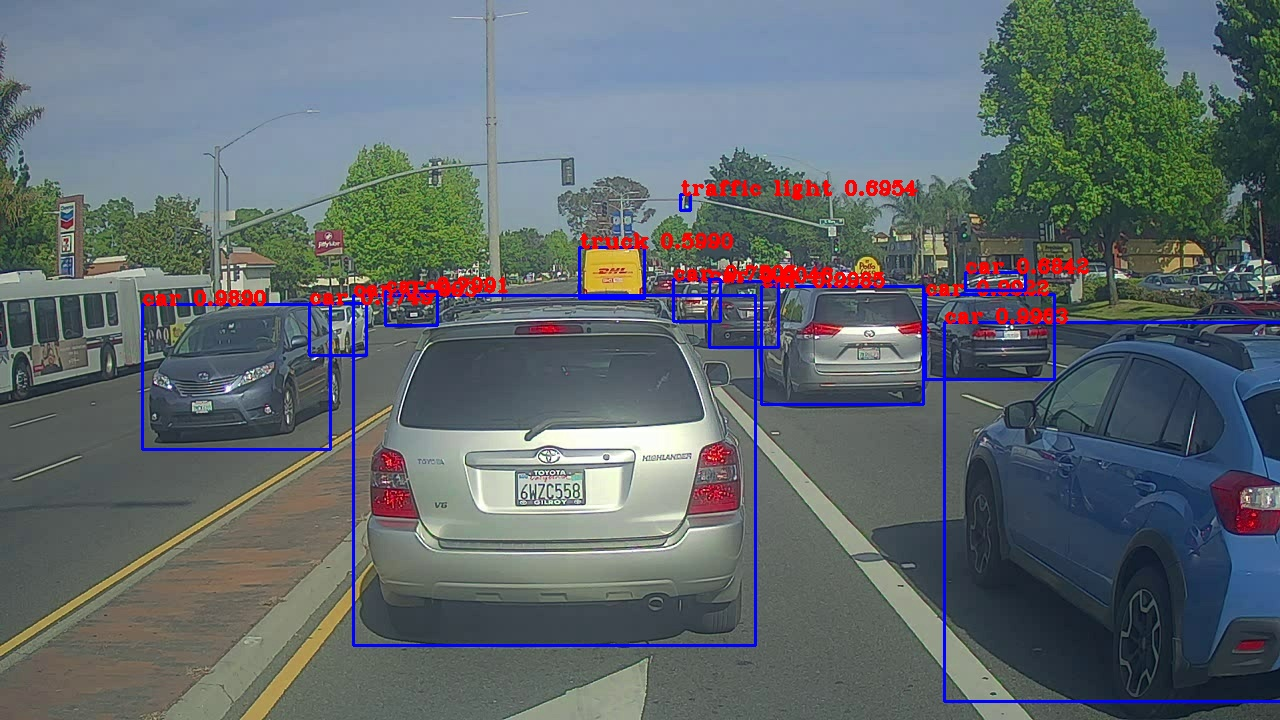

In [ ]:
pretrdet('data/test_images/test.jpg')

Fine tune (retrain) de detector
Download the PASCAL VOC 2007 data set. 
 https://www.kaggle.com/zaraks/pascal-voc-2007


In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -O ./data/voc2007_raw.tar
!mkdir -p ./data/voc2007_raw
!tar -xf ./data/voc2007_raw.tar -C ./data/voc2007_raw

URL transformed to HTTPS due to an HSTS policy
--2021-06-30 18:50:51--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘./data/voc2007_raw.tar’

./data/voc2007_raw. 100%[===================>] 438.72M  18.9MB/s    in 24s     

2021-06-30 18:51:16 (18.2 MB/s) - ‘./data/voc2007_raw.tar’ saved [460032000/460032000]



In [ ]:
!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2021-06-30 18:52:21.242428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0630 18:52:23.457890 140688216344448 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0630 18:52:23.461394 140688216344448 voc2012.py:97] Image list loaded: 2501
100% 2501/2501 [00:06<00:00, 370.62it/s]
I0630 18:52:30.216182 140688216344448 voc2012.py:106] Done
2021-06-30 18:52:31.180492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0630 18:52:33.017861 140522279294848 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 

2021-06-30 18:52:46.408363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0630 18:52:48.134696 140437078357888 visualize_dataset.py:22] classes loaded
2021-06-30 18:52:48.135153: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-30 18:52:48.136054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-06-30 18:52:48.140613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-30 18:52:48.141035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681

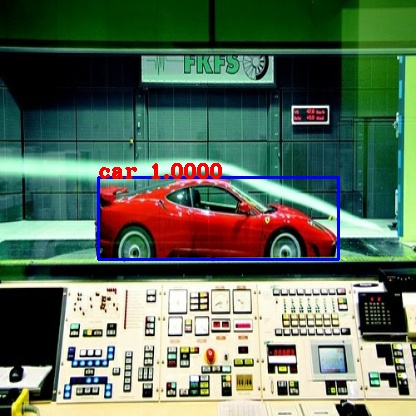

In [ ]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

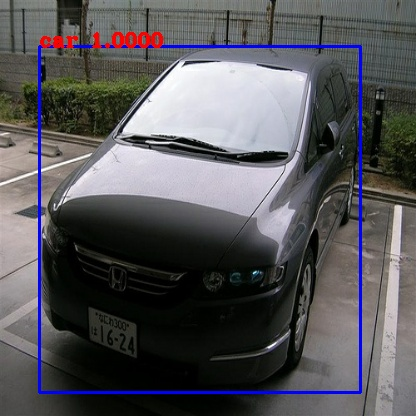

In [ ]:
Image(filename='./img4.jpg')

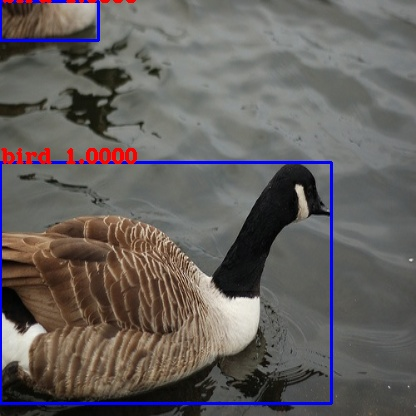

In [ ]:
from IPython.display import Image
Image(filename='./img5.jpg')

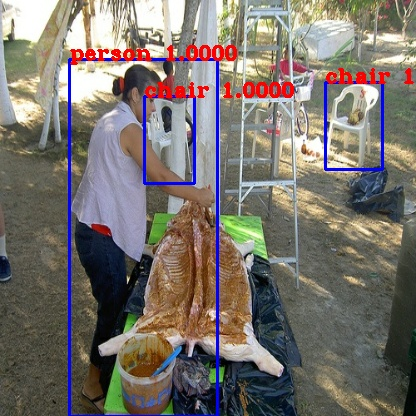

In [ ]:
Image(filename='./img1.jpg')

In [ ]:
Image(filename='./img2.jpg')

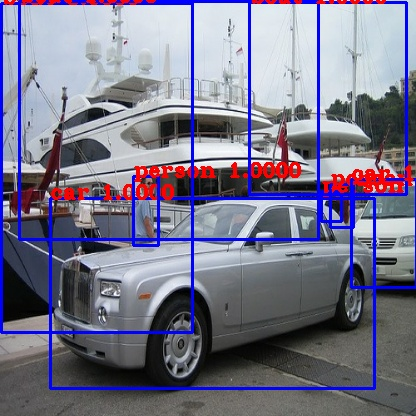

In [ ]:
Image(filename='./img3.jpg')

In [ ]:
# Pascal Voc did well

Pascal Voc is very certain, with 100% probability 

---

it correctly classified many objects with corresponding classes

retrain the model using the PASCAL VOC train/validation images


In [ ]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-06-30 19:37:56.584034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-06-30 19:37:58.322645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-30 19:37:58.323452: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-06-30 19:37:58.327761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-30 19:37:58.328173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-30 19:37:58.328201: I tensorflow/stream_executor/platform/def

Apply the fine tuned weights on the images from test_images folder.


In [ ]:
def calibrated(pathy):
  FLAGS.num_classes = 20
  FLAGS.classes = 'data/voc2012.names'
  FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
  FLAGS.image = pathy #'data/test_images/test.jpg'

  # Lower threshold due to insufficient training
  FLAGS.yolo_iou_threshold = 0.2
  FLAGS.yolo_score_threshold = 0.2

  if FLAGS.tiny:
      yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  else:
      yolo = YoloV3(classes=FLAGS.num_classes)

  yolo.load_weights(FLAGS.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0630 19:45:57.830711 140640360896384 <ipython-input-42-bf4aeeadfdc6>:17] weights loaded
I0630 19:45:57.833767 140640360896384 <ipython-input-42-bf4aeeadfdc6>:20] classes loaded
I0630 19:45:57.938827 140640360896384 <ipython-input-42-bf4aeeadfdc6>:31] time: 0.08246326446533203
I0630 19:45:57.939770 140640360896384 <ipython-input-42-bf4aeeadfdc6>:33] detections:
I0630 19:45:57.946892 140640360896384 <ipython-input-42-bf4aeeadfdc6>:37] 	car, 0.4379180669784546, [0.10724971 0.3900154  0.75852454 0.92438173]


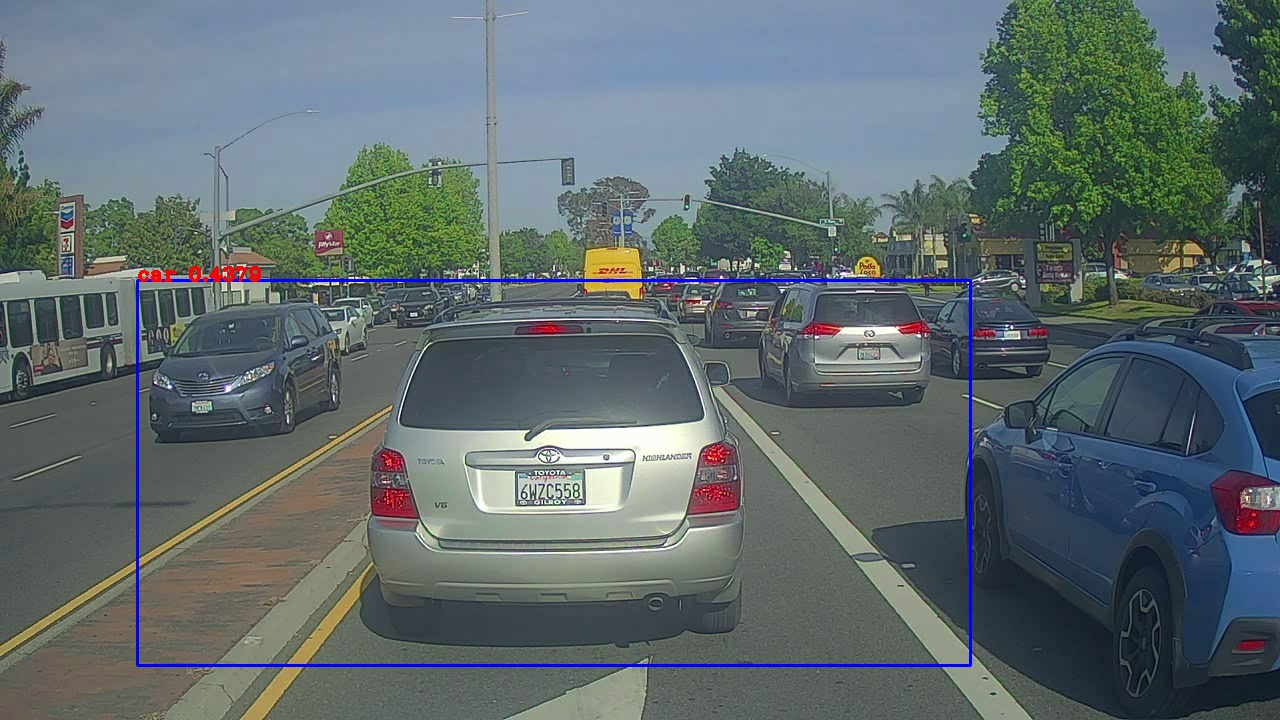

In [ ]:
calibrated('data/test_images/test.jpg')

I0630 19:46:07.427582 140640360896384 <ipython-input-42-bf4aeeadfdc6>:17] weights loaded
I0630 19:46:07.431098 140640360896384 <ipython-input-42-bf4aeeadfdc6>:20] classes loaded
I0630 19:46:07.528286 140640360896384 <ipython-input-42-bf4aeeadfdc6>:31] time: 0.07717323303222656
I0630 19:46:07.529233 140640360896384 <ipython-input-42-bf4aeeadfdc6>:33] detections:


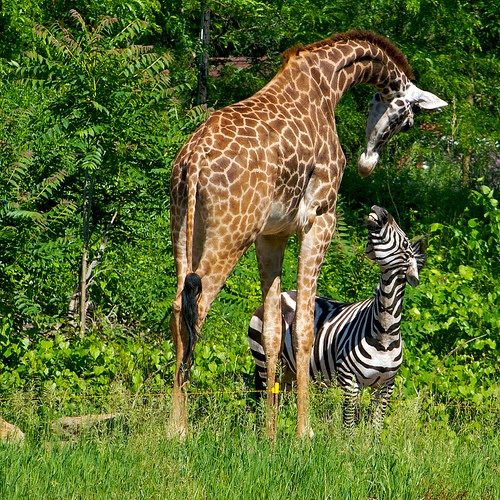

In [ ]:
calibrated('data/test_images/giraffe.jpg')

I0630 19:46:16.099488 140640360896384 <ipython-input-42-bf4aeeadfdc6>:17] weights loaded
I0630 19:46:16.108246 140640360896384 <ipython-input-42-bf4aeeadfdc6>:20] classes loaded
I0630 19:46:16.203560 140640360896384 <ipython-input-42-bf4aeeadfdc6>:31] time: 0.07706785202026367
I0630 19:46:16.204551 140640360896384 <ipython-input-42-bf4aeeadfdc6>:33] detections:


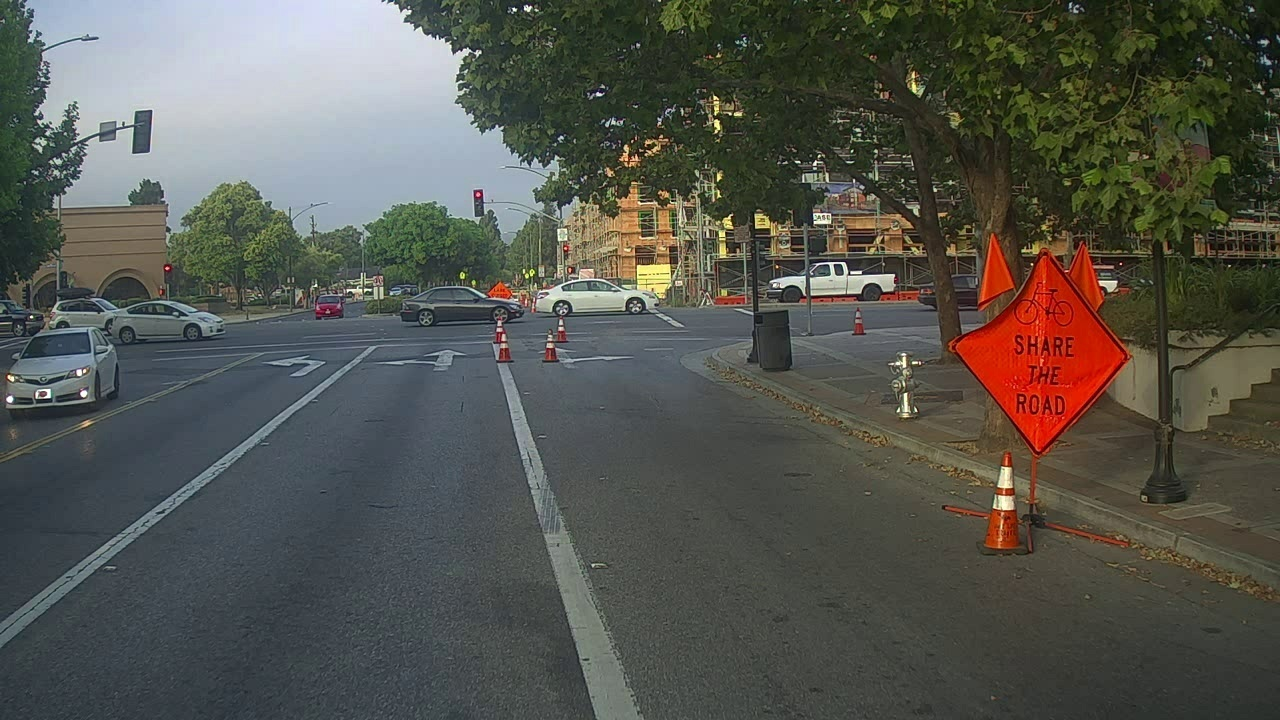

In [ ]:
calibrated('data/test_images/0004.jpg')